# Loan Default Prediction - Arjun Ghelani

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings

_warn_filters = [
    'ignore:divide by zero encountered in matmul:RuntimeWarning:sklearn.utils.extmath',
    'ignore:overflow encountered in matmul:RuntimeWarning:sklearn.utils.extmath',
    'ignore:invalid value encountered in matmul:RuntimeWarning:sklearn.utils.extmath',
]
existing_pywarnings = os.environ.get('PYTHONWARNINGS', '')
existing_parts = [p for p in existing_pywarnings.split(',') if p]
for rule in _warn_filters:
    if rule not in existing_parts:
        existing_parts.append(rule)
os.environ['PYTHONWARNINGS'] = ','.join(existing_parts)

warnings.filterwarnings('ignore')
warnings.filterwarnings(
    'ignore',
    message='.*encountered in matmul',
    category=RuntimeWarning,
    module=r'sklearn\\.utils\\.extmath',
)

/Users/arjun/Documents/Purpose Financial Data Challenge/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.base import clone
from sklearn.metrics import (
    log_loss, roc_auc_score, brier_score_loss,
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, fbeta_score, precision_score, recall_score,
    make_scorer
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

SEED = 42
BETA = 1.5
np.random.seed(SEED)
sns.set_style('whitegrid')

# Consistent plot style
COLORS = {'primary': '#4c72b0', 'green': '#55a868', 'orange': '#dd8452', 'red': '#c44e52'}
MODEL_COLORS = {
    'Logistic Regression': COLORS['primary'], 'Random Forest': COLORS['green'],
    'XGBoost': COLORS['orange'], 'LightGBM': COLORS['red'],
}
FIG_SMALL = (7, 4)
FIG_MEDIUM = (8, 5)
FIG_WIDE = (10, 4)

print(f'Imports OK | BETA = {BETA}')

Imports OK | BETA = 1.5


`BETA=1.5` weights recall moderately over precision: in a lending context, missing a true default (false negative) is costlier than flagging a good borrower for review (false positive).

In [3]:
train = pd.read_csv('../train.csv')
test = pd.read_csv('../test.csv')

print(f'Train shape: {train.shape}')
print(f'Test shape:  {test.shape}')
print(f'\nTarget distribution:')
print(train['target'].value_counts())
print(f'Default rate: {train["target"].mean():.4f}')

Train shape: (20839, 13)
Test shape:  (1000, 12)

Target distribution:
target
0    18710
1     2129
Name: count, dtype: int64
Default rate: 0.1022


## Exploratory Data Analysis

In [4]:
print(f'Shape: {train.shape}')
print(f'\nDtypes:\n{train.dtypes}')
print(f'\nMissing values:\n{train.isnull().sum().to_string()}')

sentinel_count = (train['number_dependants'] == -1).sum()
sentinel_rate = train.loc[train['number_dependants'] == -1, 'target'].mean()
normal_rate = train.loc[train['number_dependants'] >= 0, 'target'].mean()
print(f'\n number_dependants == -1: {sentinel_count} rows')
print(f'  Default rate (sentinel): {sentinel_rate:.4f} vs normal: {normal_rate:.4f}')

dob = pd.to_datetime(train['date_of_birth'], errors='coerce')
age = (pd.Timestamp('2026-02-11') - dob).dt.days / 365.25
print('\n')
print('Number of people over 100 years old: ', len(age.loc[age > 100]))
print('Min age:', age.min())
print('Max age:', age.max())

Shape: (20839, 13)

Dtypes:
id                            int64
date_of_birth                object
number_dependants             int64
credit_utilization          float64
debt_to_income_ratio        float64
monthly_income                int64
number_open_credit_lines      int64
number_open_loans             int64
number_90_days_past_due       int64
number_charged_off            int64
score1                        int64
score2                        int64
target                        int64
dtype: object

Missing values:
id                          0
date_of_birth               0
number_dependants           0
credit_utilization          0
debt_to_income_ratio        0
monthly_income              0
number_open_credit_lines    0
number_open_loans           0
number_90_days_past_due     0
number_charged_off          0
score1                      0
score2                      0
target                      0

 number_dependants == -1: 209 rows
  Default rate (sentinel): 0.0861 vs normal: 0.

There are no missing values in the raw data, but the `number_dependents` column has 209 entries where the value is -1. The default rate of these rows is 8.6%, compared to the overall 10.2%. 

There are also 7 rows where people are aged over 100 years old, with one person reaching 196 years. This is such a small percentage of the data, so I chose not to remove it. 

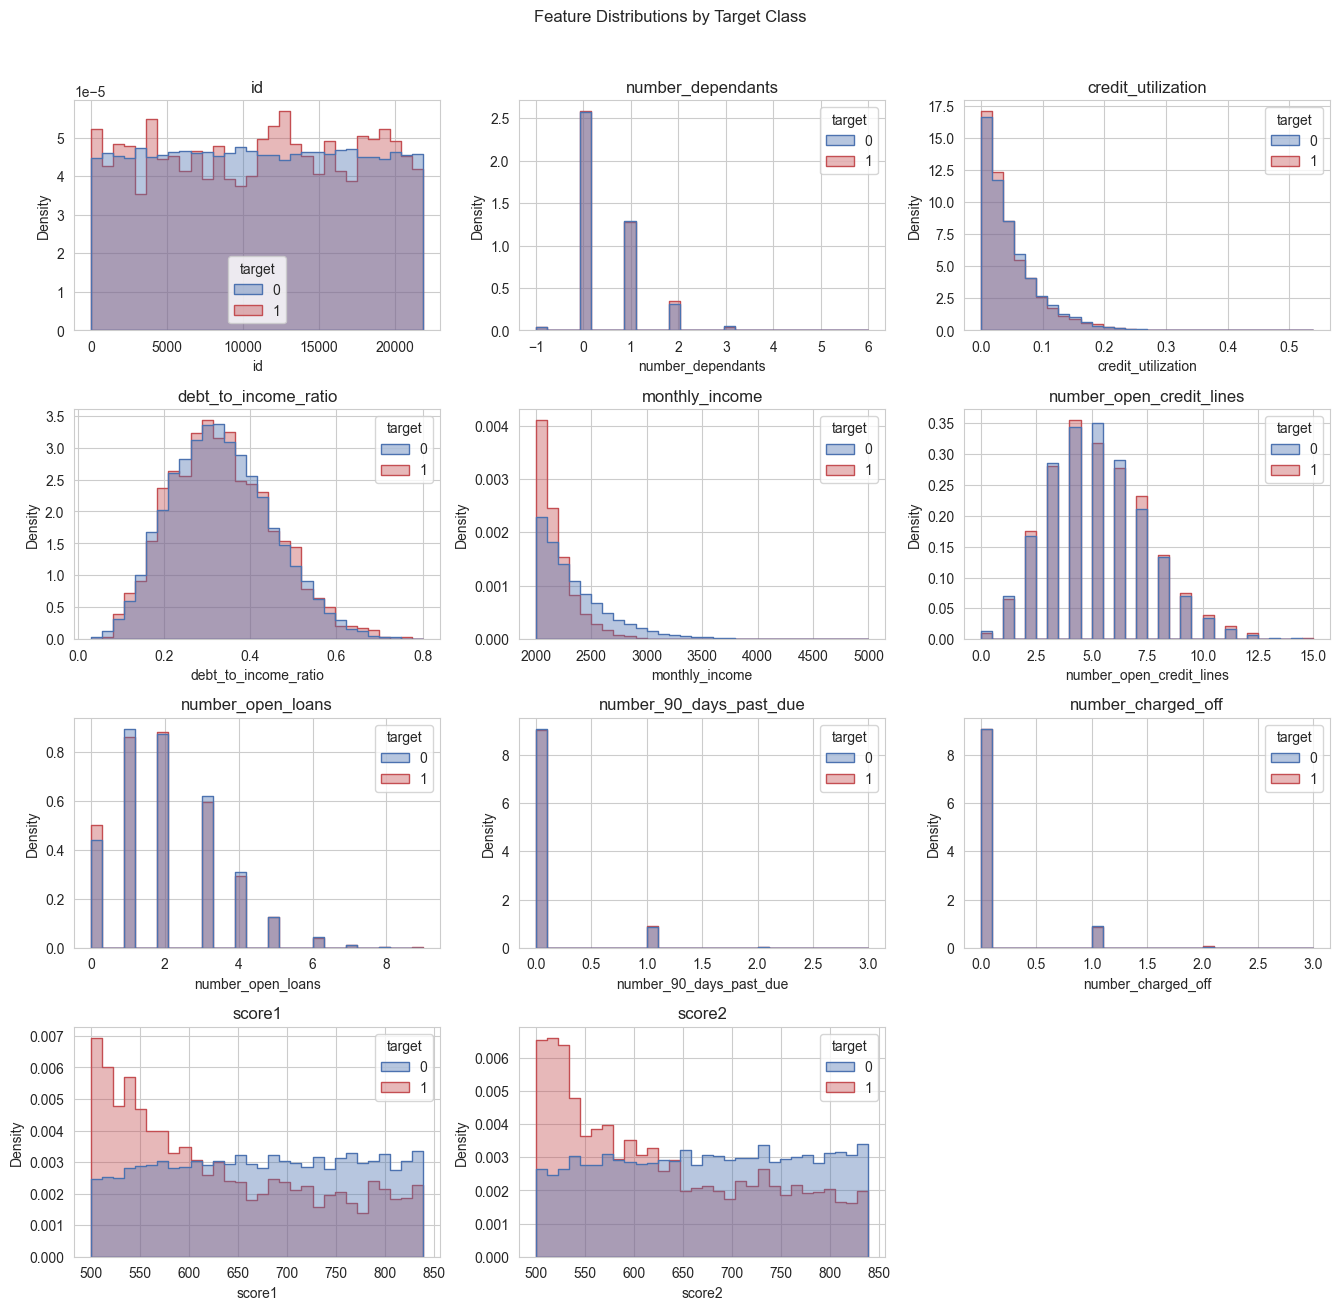

In [5]:
numeric_cols = train.select_dtypes(include='number').columns.drop('target', errors='ignore')
n = len(numeric_cols)
ncols = 3
nrows = int(np.ceil(n / ncols)) if n > 0 else 1
fig, axes = plt.subplots(nrows, ncols, figsize=(4.5 * ncols, 3.2 * nrows))
axes = np.array(axes).reshape(-1)
for ax, col in zip(axes, numeric_cols):
    sns.histplot(
        data=train, x=col, hue='target', bins=30,
        stat='density', common_norm=False, element='step',
        fill=True, alpha=0.4, ax=ax,
        palette={0: COLORS['primary'], 1: COLORS['red']},
    )
    ax.set_title(col)
for ax in axes[n:]:
    ax.axis('off')
fig.suptitle('Feature Distributions by Target Class', y=1.02)
plt.tight_layout()
plt.show()

The histograms reveal that `score1` and `score2` provide the clearest univariate separation — low-score borrowers cluster heavily with defaults. `monthly_income` also shows a higher cluster towards lower values for defaulters. `number_open_credit_lines` also shows that those with more credit lines open tend to default slightly more. Most other features have nearly overlapping class distributions.

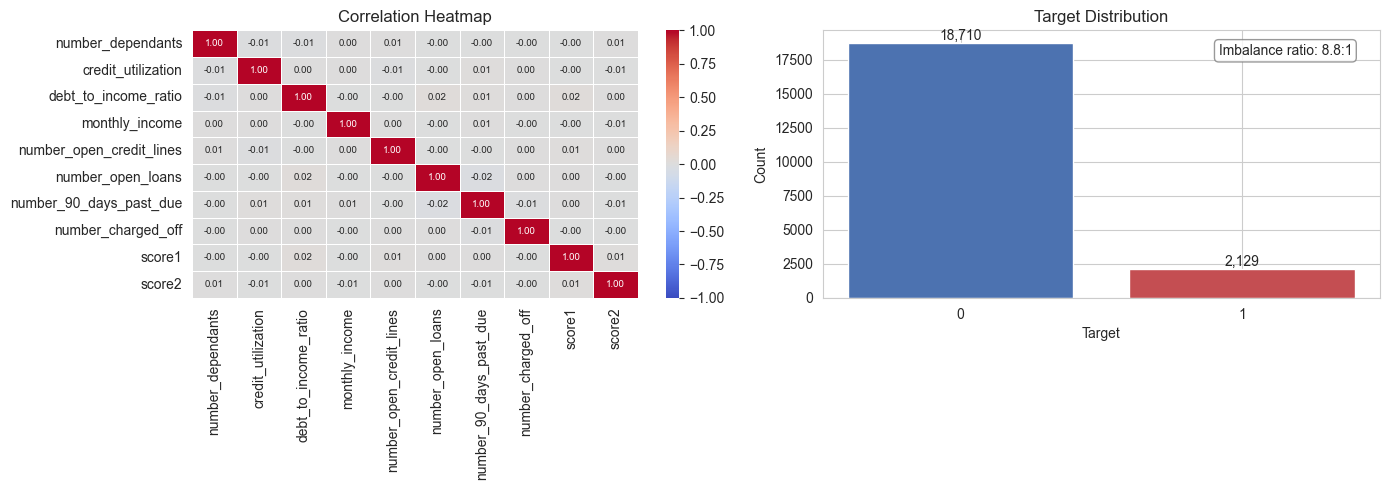

In [6]:
numeric_df = train.select_dtypes(include='number')
numeric_df.drop(columns='id', inplace=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlation heatmap
corr = numeric_df.drop(columns=['target'], errors='ignore').corr()
# mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            annot=True, fmt='.2f', linewidths=0.5, ax=axes[0], annot_kws={'size': 7})
axes[0].set_title('Correlation Heatmap')

counts = train['target'].value_counts().sort_index()
bars = axes[1].bar(counts.index.astype(str), counts.values,
                   color=[COLORS['primary'], COLORS['red']])
axes[1].set_xlabel('Target')
axes[1].set_ylabel('Count')
axes[1].set_title('Target Distribution')
for bar, count in zip(bars, counts.values):
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f'{count:,}', ha='center', va='bottom', fontsize=10)
imbalance = counts[0] / counts[1]
axes[1].text(0.95, 0.95, f'Imbalance ratio: {imbalance:.1f}:1',
             transform=axes[1].transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', alpha=0.8))

plt.tight_layout()
plt.show()

Raw features show low pairwise correlation. Low collinearity is good (regularization won't need to arbitrate between redundant signals), but it also means the raw feature space lacks the compound risk patterns that drive default. This confirms the need to *create* correlated features (interactions, ratios, composite scores) that capture multi-factor risk profiles.

## Feature Engineering

With our original hisogram plots showing that `credit score` , `monthly income`, and `number of open credit lines` tend to have the largest difference in default rates, I tried engineering features around these. I combined both credit scores into aggregate metrics, hoping that the models could understand how the two scores together would influence default rates, as `score1` and `score2` themselves have very low correlation. 

I also tried some semi-arbitrary cutoffs on income, debt-to-income, and credit scores to create aggregate risk features about an indidvidual. I ended up with 33 features, more than double the original 12. If a feature is not useful, I hope that regularization remove them from the model's base, and we do not inflitrate too much noise into the models. 

The `fe_params` pattern fits statistics (medians, quantiles) on train only and reuses them on validation/test — this prevents leakage from future data influencing feature construction.

In [7]:
def engineer_features(df, fe_params=None):
    df = df.copy()
    fe_params = {} if fe_params is None else dict(fe_params)

    # Age from DOB, using Feb 11th
    age_ref = pd.Timestamp('2026-02-11')
    dob = pd.to_datetime(df['date_of_birth'], errors='coerce')
    df['age'] = (age_ref - dob).dt.days / 365.25

    df['total_delinquency'] = df['number_90_days_past_due'] + df['number_charged_off']

    # Account/debt features
    df['monthly_debt'] = df['debt_to_income_ratio'] * df['monthly_income']

    df['score_min'] = np.minimum(df['score1'], df['score2'])
    df['score_max'] = np.maximum(df['score1'], df['score2'])
    df['score_sq'] = df['score_min'] * df['score_max']
    df['score_diff'] = df['score_max'] - df['score_min']

    df['low_score'] = (df['score_min'] < 600).astype(int)
    df['low_income'] = (df['monthly_income'] < 2100).astype(int)
    df['high_dti'] = (df['debt_to_income_ratio'] > 0.4).astype(int)
    df['risk_index'] = df['low_score'] + df['high_dti'] + df['low_income']
    
    # Capacity
    df['residual_income'] = df['monthly_income'] - df['monthly_debt']

    # Financial stress per dependence/account/credit line
    df['income_per_dependant'] = df['monthly_income'] / (df['number_dependants'] + 1.01)
    df['zero_open_loans'] = df['number_open_loans'] == 0
    med_credit = fe_params.get('med_credit', df['number_open_credit_lines'].median())
    df['dist_from_med_credit'] = df['number_open_credit_lines'] - med_credit
    df['negative_dependant'] = df['number_dependants'] < 0

    # Tail-risk flags (learn sharp cliffs)
    util_q30 = fe_params.get('util_q30', df['credit_utilization'].quantile(0.30))
    df['low_util'] = (df['credit_utilization'] <= util_q30).astype(int)

    # Score stability and disagreement
    df['score_avg'] = (df['score_min'] + df['score_max']) / 2
    df['score_gap_pct'] = df['score_diff'] / (df['score_avg'] + 1e-6)

    # retirement age
    df['age_65plus'] = (df['age'] >= 65).astype(int)

    # Score and income interaction features, aggregate deliquency features
    df['score_per_income_unit'] = df['score_min'] / (df['monthly_income'] / 1000.0)
    df['score_x_income'] = df['score_min'] * (df['monthly_income'] / 1000.0)
    df['both_scores_below_600'] = (df['score_max'] < 600).astype(int)
    df['both_delinquency_types'] = (
        (df['number_90_days_past_due'] > 0) & (df['number_charged_off'] > 0)
    ).astype(int)
    
    # Composite risk score — unweighted count of risk factors
    df['composite_risk_score'] = (
        (df['score_min'] < 600).astype(int) +
        (df['monthly_income'] < 2100).astype(int) +
        (df['debt_to_income_ratio'] > 0.4).astype(int) +
        df['both_delinquency_types']
    )

    # Drop raw columns used only as intermediates
    drop_cols = ['score1', 'score2']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    params_used = {
        'util_q30': util_q30,
        'med_credit': med_credit,
    }

    # Drop non-feature columns
    df = df.drop(columns=['id', 'date_of_birth'], errors='ignore')

    return df, params_used


print('Feature engineering function defined.')


Feature engineering function defined.


In [8]:
# Split BEFORE feature engineering to prevent val data leaking into train statistics
train_raw, val_raw = train_test_split(train, test_size=0.2, stratify=train['target'], random_state=SEED)

# Engineer features: fit stats on train only, apply same stats to val and test
train_fe, fe_params = engineer_features(train_raw)
val_fe, _ = engineer_features(val_raw, fe_params=fe_params)
test_fe, _ = engineer_features(test, fe_params=fe_params)

print(f"Fitted FE params (train-only): util_q30={fe_params['util_q30']:.4f}, med_credit={fe_params['med_credit']:.4f}")

y_train = train_fe.pop('target')
X_train = train_fe
y_val = val_fe.pop('target')
X_val = val_fe
X_test = test_fe

# Full training set (for final retraining later) — uses its own fe_params
full_fe, full_fe_params = engineer_features(train)
y = full_fe.pop('target')
X = full_fe

# Drop constant features based on training split only, then apply same drop everywhere
constant_cols = [c for c in X_train.columns if X_train[c].nunique(dropna=False) <= 1]
if constant_cols:
    X_train = X_train.drop(columns=constant_cols)
    X_val = X_val.drop(columns=constant_cols, errors='ignore')
    X_test = X_test.drop(columns=constant_cols, errors='ignore')
    X = X.drop(columns=constant_cols, errors='ignore')

selected_feature_cols = list(X_train.columns)

print(f'Train: {X_train.shape[0]} rows | Val: {X_val.shape[0]} rows')
print(f'Train default rate: {y_train.mean():.4f} | Val default rate: {y_val.mean():.4f}')
print(f'Feature count: {X_train.shape[1]}')
if constant_cols:
    print(f'Dropped constant features ({len(constant_cols)}): {constant_cols}')
print(f'Features: {list(X_train.columns)}')


Fitted FE params (train-only): util_q30=0.0180, med_credit=5.0000
Train: 16671 rows | Val: 4168 rows
Train default rate: 0.1022 | Val default rate: 0.1022
Feature count: 33
Features: ['number_dependants', 'credit_utilization', 'debt_to_income_ratio', 'monthly_income', 'number_open_credit_lines', 'number_open_loans', 'number_90_days_past_due', 'number_charged_off', 'age', 'total_delinquency', 'monthly_debt', 'score_min', 'score_max', 'score_sq', 'score_diff', 'low_score', 'low_income', 'high_dti', 'risk_index', 'residual_income', 'income_per_dependant', 'zero_open_loans', 'dist_from_med_credit', 'negative_dependant', 'low_util', 'score_avg', 'score_gap_pct', 'age_65plus', 'score_per_income_unit', 'score_x_income', 'both_scores_below_600', 'both_delinquency_types', 'composite_risk_score']


### Evaluation Helpers

These shared functions ensure every model is measured on identical footing. One decision I made is that thresholds are optimized via inner CV on training folds only, allowing us to test on unseen data later on (validation).

In [9]:
fbeta_label = f'F{BETA}'


def best_fbeta_at_threshold(y_true, y_proba):
    """Find the threshold that maximizes F-beta and return (fbeta, threshold)."""
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    fbeta_scores = (1 + BETA**2) * (precisions[:-1] * recalls[:-1]) / (
        BETA**2 * precisions[:-1] + recalls[:-1] + 1e-10
    )
    best_idx = np.argmax(fbeta_scores)
    return fbeta_scores[best_idx], thresholds[best_idx]


def weighted_log_loss(y_true, y_proba, pos_weight):
    y_arr = np.asarray(y_true)
    sample_weight = np.where(y_arr == 1, pos_weight, 1.0)
    return log_loss(y_true, y_proba, sample_weight=sample_weight)


def evaluate_predictions_at_threshold(y_true, y_proba, threshold, pos_weight):
    preds = (y_proba >= threshold).astype(int)
    prec = precision_score(y_true, preds, zero_division=0)
    rec = recall_score(y_true, preds, zero_division=0)
    fb = fbeta_score(y_true, preds, beta=BETA, zero_division=0)
    ll = log_loss(y_true, y_proba)
    wll = weighted_log_loss(y_true, y_proba, pos_weight)
    auc = roc_auc_score(y_true, y_proba)
    tn, fp, fn, tp = confusion_matrix(y_true, preds, labels=[0, 1]).ravel()
    fpr = fp / (fp + tn + 1e-10)
    flagged_pct = preds.mean() * 100
    return {
        'fbeta': fb,
        'precision': prec,
        'recall': rec,
        'log_loss': ll,
        'weighted_log_loss': wll,
        'auc': auc,
        'fp': int(fp),
        'fn': int(fn),
        'tp': int(tp),
        'tn': int(tn),
        'fpr': fpr,
        'flagged_pct': flagged_pct,
    }


def select_threshold_via_inner_cv(base_model, X_data, y_data, n_splits=3, random_state=SEED, calibrate=False):
    """
    Select threshold using inner CV on training data only.
    Returns (mean_threshold, std_threshold, list_thresholds).
    """
    inner_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    thresholds = []
    for tr_idx, va_idx in inner_cv.split(X_data, y_data):
        X_tr, X_va = X_data.iloc[tr_idx], X_data.iloc[va_idx]
        y_tr, y_va = y_data.iloc[tr_idx], y_data.iloc[va_idx]

        model = clone(base_model)
        if calibrate:
            model = CalibratedClassifierCV(model, method='sigmoid', cv=3)

        model.fit(X_tr, y_tr)
        proba = model.predict_proba(X_va)[:, 1]
        _, th = best_fbeta_at_threshold(y_va, proba)
        thresholds.append(th)

    return float(np.mean(thresholds)), float(np.std(thresholds)), thresholds


def evaluate_model_via_cv(model, X_data, y_data, n_splits=5, random_state=SEED, pos_weight=None):
    """
    Evaluate one model with stratified CV.
    Threshold is selected via inner CV on each fold's training portion only.
    Returns (fold_df, summary_dict, oof_proba).
    """
    if pos_weight is None:
        pos_weight = (y_data == 0).sum() / max((y_data == 1).sum(), 1)

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof_proba = np.zeros(len(y_data), dtype=float)
    fold_rows = []

    for fold_id, (tr_idx, va_idx) in enumerate(cv.split(X_data, y_data), start=1):
        X_tr, X_va = X_data.iloc[tr_idx], X_data.iloc[va_idx]
        y_tr, y_va = y_data.iloc[tr_idx], y_data.iloc[va_idx]

        fold_model = clone(model)
        fold_model.fit(X_tr, y_tr)
        proba = fold_model.predict_proba(X_va)[:, 1]
        oof_proba[va_idx] = proba

        th_mean, th_std, _ = select_threshold_via_inner_cv(
            model, X_tr, y_tr, n_splits=3, random_state=random_state,
        )
        fold_metrics = evaluate_predictions_at_threshold(y_va, proba, th_mean, pos_weight)
        threshold = th_mean

        fold_rows.append({
            'Fold': fold_id,
            'Threshold': threshold,
            'Fbeta': fold_metrics['fbeta'],
            'Precision': fold_metrics['precision'],
            'Recall': fold_metrics['recall'],
            'Log Loss': fold_metrics['log_loss'],
            'Weighted Log Loss': fold_metrics['weighted_log_loss'],
            'AUC': fold_metrics['auc'],
            'Brier': brier_score_loss(y_va, proba),
            'FP': fold_metrics['fp'],
            'FN': fold_metrics['fn'],
            'FPR': fold_metrics['fpr'],
            'Flagged %': fold_metrics['flagged_pct'],
        })

    fold_df = pd.DataFrame(fold_rows)
    y_arr = np.asarray(y_data)

    summary = {
        'mean_threshold': fold_df['Threshold'].mean(),
        'std_threshold': fold_df['Threshold'].std(ddof=0),
        'mean_fbeta': fold_df['Fbeta'].mean(),
        'std_fbeta': fold_df['Fbeta'].std(ddof=0),
        'mean_precision': fold_df['Precision'].mean(),
        'std_precision': fold_df['Precision'].std(ddof=0),
        'mean_recall': fold_df['Recall'].mean(),
        'std_recall': fold_df['Recall'].std(ddof=0),
        'mean_log_loss': fold_df['Log Loss'].mean(),
        'std_log_loss': fold_df['Log Loss'].std(ddof=0),
        'mean_weighted_log_loss': fold_df['Weighted Log Loss'].mean(),
        'std_weighted_log_loss': fold_df['Weighted Log Loss'].std(ddof=0),
        'mean_auc': fold_df['AUC'].mean(),
        'std_auc': fold_df['AUC'].std(ddof=0),
        'mean_brier': fold_df['Brier'].mean(),
        'std_brier': fold_df['Brier'].std(ddof=0),
        'mean_fp': fold_df['FP'].mean(),
        'mean_fn': fold_df['FN'].mean(),
        'mean_fpr': fold_df['FPR'].mean(),
        'oof_log_loss': log_loss(y_arr, oof_proba),
        'oof_weighted_log_loss': weighted_log_loss(y_arr, oof_proba, pos_weight),
        'oof_auc': roc_auc_score(y_arr, oof_proba),
        'oof_brier': brier_score_loss(y_arr, oof_proba),
    }

    return fold_df, summary, oof_proba


def evaluate_model_on_holdout(
    model,
    X_train_data,
    y_train_data,
    X_holdout,
    y_holdout,
    pos_weight,
    n_threshold_splits=3,
    random_state=SEED,
    fbeta_label=None,
):
    """Fit on train split, evaluate once on holdout, threshold chosen from train-only inner CV."""
    fbeta_label = f'F{BETA}' if fbeta_label is None else fbeta_label

    fitted_model = clone(model)
    fitted_model.fit(X_train_data, y_train_data)
    holdout_proba = fitted_model.predict_proba(X_holdout)[:, 1]

    th_mean, th_std, _ = select_threshold_via_inner_cv(
        model,
        X_train_data,
        y_train_data,
        n_splits=n_threshold_splits,
        random_state=random_state,
    )
    metrics = evaluate_predictions_at_threshold(y_holdout, holdout_proba, th_mean, pos_weight)

    row = {
        'Threshold': th_mean,
        'Threshold Std': th_std,
        'Threshold Source': 'inner_cv_mean',
        'Log Loss': metrics['log_loss'],
        'Weighted Log Loss': metrics['weighted_log_loss'],
        'AUC': metrics['auc'],
        'Brier': brier_score_loss(y_holdout, holdout_proba),
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'FP': metrics['fp'],
        'FN': metrics['fn'],
        'FPR': metrics['fpr'],
        'Flagged %': metrics['flagged_pct'],
    }
    row[fbeta_label] = metrics['fbeta']

    return fitted_model, holdout_proba, row


print('Evaluation helpers defined.')

Evaluation helpers defined.


## Model Comparison

We test four model families to understand which bias fits this problem. 

- Logistic Regression 
- Random Forest
- XGBoost 
- LightGBM

All use class-weight adjustments to handle the ~9:1 imbalance. Thresholds are selected via inner CV on training data only, and we report F-beta (F-1.5) as the main evaluation metric.

In [10]:
imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()
pos_class_weight = imbalance_ratio
cv_n_splits = 5

models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(random_state=SEED, class_weight='balanced', max_iter=3000))
    ]),
    'Random Forest': RandomForestClassifier(
        n_estimators=300, class_weight='balanced', random_state=SEED, n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=300, scale_pos_weight=imbalance_ratio,
        eval_metric='logloss', random_state=SEED, verbosity=0, n_jobs=-1
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=300, scale_pos_weight=imbalance_ratio,
        random_state=SEED, n_jobs=-1, verbose=-1
    ),
}


def cv_summary_to_row(model_name, model_group, summary, fbeta_label, extra=None):
    row = {
        'Model': model_name,
        'Model Group': model_group,
        f'CV Mean {fbeta_label}': summary['mean_fbeta'],
        f'CV Std {fbeta_label}': summary['std_fbeta'],
        'CV Mean Log Loss': summary['mean_log_loss'],
        'CV Std Log Loss': summary['std_log_loss'],
        'CV Mean Weighted Log Loss': summary['mean_weighted_log_loss'],
        'CV Std Weighted Log Loss': summary['std_weighted_log_loss'],
        'CV Mean AUC': summary['mean_auc'],
        'CV Std AUC': summary['std_auc'],
        'CV Mean Brier': summary['mean_brier'],
        'CV Std Brier': summary['std_brier'],
        'CV Mean Precision': summary['mean_precision'],
        'CV Mean Recall': summary['mean_recall'],
        'CV Mean FP': summary['mean_fp'],
        'CV Mean FN': summary['mean_fn'],
        'CV Mean FPR': summary['mean_fpr'],
        'CV Mean Threshold': summary['mean_threshold'],
        'CV Std Threshold': summary['std_threshold'],
        'CV OOF Log Loss': summary['oof_log_loss'],
        'CV OOF Weighted Log Loss': summary['oof_weighted_log_loss'],
        'CV OOF AUC': summary['oof_auc'],
        'CV OOF Brier': summary['oof_brier'],
    }
    if extra:
        row.update(extra)
    return row


baseline_cv_rows = []
baseline_cv_fold_details = {}
cv_oof_probas = {}

print(f'Running {cv_n_splits}-fold CV for baseline models...')
for name, model in models.items():
    fold_df, cv_summary, oof_proba = evaluate_model_via_cv(
        model,
        X_train,
        y_train,
        n_splits=cv_n_splits,
        random_state=SEED,
        pos_weight=pos_class_weight,
    )

    baseline_cv_fold_details[name] = fold_df
    cv_oof_probas[name] = oof_proba
    baseline_cv_rows.append(cv_summary_to_row(name, 'Baseline', cv_summary, fbeta_label))

    print(
        f"{name:25s} CV Mean {fbeta_label}: {cv_summary['mean_fbeta']:.4f} ± {cv_summary['std_fbeta']:.4f}  "
        f"CV Mean Weighted LogLoss: {cv_summary['mean_weighted_log_loss']:.5f} ± {cv_summary['std_weighted_log_loss']:.5f}"
    )

baseline_cv_results = pd.DataFrame(baseline_cv_rows)
results_df = baseline_cv_results.copy()

print(f'\nTrain default rate: {y_train.mean():.4f}')
print(f'Class imbalance ratio (0:1): {imbalance_ratio:.2f}:1')


Running 5-fold CV for baseline models...
Logistic Regression       CV Mean F1.5: 0.4185 ± 0.0180  CV Mean Weighted LogLoss: 0.56261 ± 0.01193
Random Forest             CV Mean F1.5: 0.3909 ± 0.0097  CV Mean Weighted LogLoss: 1.08144 ± 0.04702
XGBoost                   CV Mean F1.5: 0.3641 ± 0.0113  CV Mean Weighted LogLoss: 1.43240 ± 0.04228
LightGBM                  CV Mean F1.5: 0.3828 ± 0.0060  CV Mean Weighted LogLoss: 0.85611 ± 0.02317

Train default rate: 0.1022
Class imbalance ratio (0:1): 8.79:1


Logistic Regression leads on F1.5 (0.418 ± 0.018), followed by Random Forest (0.391), LightGBM (0.383), and XGBoost (0.364). LR outperforming tree ensembles at baseline suggests that the tree-based methods may be overfitting to the CV training data and not performing as well on the 1/5 that they don't see. We will tune parameters later, ensuring that pruning is one of the methods used for the tree-based methods

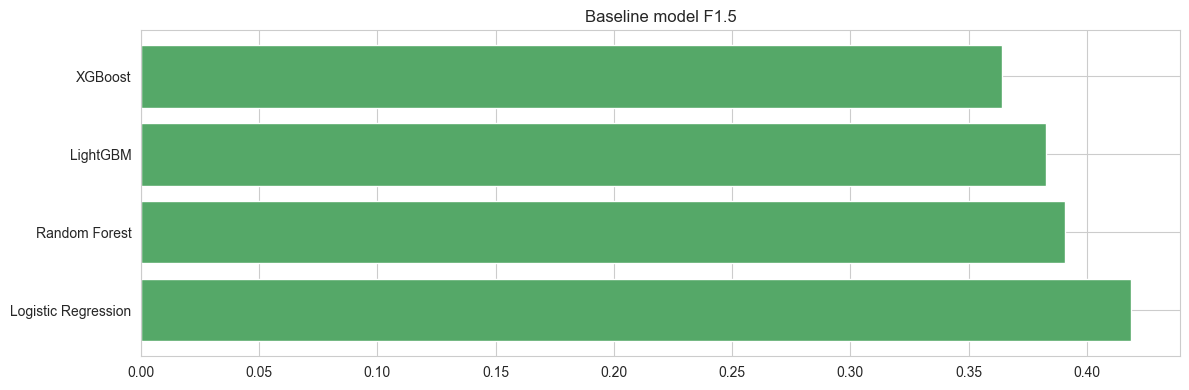

In [11]:
baseline_cols = [
    'Model',
    f'CV Mean {fbeta_label}',
    f'CV Std {fbeta_label}',
    'CV Mean Weighted Log Loss',
    'CV Std Weighted Log Loss',
    'CV Mean AUC',
    'CV Mean Brier',
    'CV Mean Precision',
    'CV Mean Recall',
    'CV Mean FP',
    'CV Mean FN',
]

fig, axes = plt.subplots(1, 1, figsize=(12, 4))

fb_sorted = baseline_cv_results.sort_values(f'CV Mean {fbeta_label}', ascending=False)
axes.barh(fb_sorted['Model'], fb_sorted[f'CV Mean {fbeta_label}'], color=COLORS['green'])
axes.set_title(f'Baseline model {fbeta_label}')

plt.tight_layout()
plt.show()


## Hyperparameter Tuning

We tune all four models. `RandomizedSearchCV` with F-beta scoring ensures the tuning objective matches our deployment goal, and re-evaluation through the same CV evaluator makes sure our splits are the same constantly

In [12]:
cv = StratifiedKFold(n_splits=cv_n_splits, shuffle=True, random_state=SEED)
EVAL_SEED = SEED + 1  # Different seed for post-tuning evaluation to avoid fold reuse

# Custom F-beta scorer: finds optimal threshold on each CV fold
def _fbeta_scorer(y_true, y_proba):
    if y_proba.ndim == 2:
        y_proba = y_proba[:, 1]
    fb, _ = best_fbeta_at_threshold(y_true, y_proba)
    return fb

fbeta_cv_scorer = make_scorer(_fbeta_scorer, response_method='predict_proba')

search_spaces = {
    'Logistic Regression': {
        'estimator': clone(models['Logistic Regression']),
        'param_dist': [
            {
                'model__solver': ['liblinear'],
                'model__penalty': ['l1', 'l2'],
                'model__C': [1e-2, 1e-1, 1, 10, 100],
                'model__class_weight': ['balanced'],
                'model__max_iter': [2000],
            },
            {
                'model__solver': ['saga'],
                'model__penalty': ['l1', 'l2'],
                'model__C': [1e-2, 1e-1, 1, 10, 100],
                'model__class_weight': ['balanced'],
                'model__max_iter': [2000],
            },
            {
                'model__solver': ['saga'],
                'model__penalty': ['elasticnet'],
                'model__l1_ratio': [0.1, 0.5, 0.9],
                'model__C': [1e-2, 1e-1, 1, 10, 100],
                'model__class_weight': ['balanced'],
                'model__max_iter': [2000],
            },
        ],
    },
    'Random Forest': {
        'estimator': clone(models['Random Forest']),
        'param_dist': {
            'n_estimators': [200, 300, 500],
            'max_depth': [3, 5, 7, 9],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 4, 8],
            'max_features': ['sqrt', 'log2', 0.5, 0.8],
            'class_weight': [None, 'balanced', 'balanced_subsample'],
        },
    },
    'XGBoost': {
        'estimator': clone(models['XGBoost']),
        'param_dist': {
            'n_estimators': [200, 300, 500],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'min_child_weight': [1, 3, 5, 10],
            'gamma': [0, 0.1, 0.3, 1.0],
            'reg_alpha': [0, 0.01, 0.1, 1.0],
            'reg_lambda': [1, 2, 5, 10],
            'scale_pos_weight': [1, imbalance_ratio / 2, imbalance_ratio, imbalance_ratio * 1.5],
        },
    },
    'LightGBM': {
        'estimator': clone(models['LightGBM']),
        'param_dist': {
            'n_estimators': [200, 300, 500],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.03, 0.05, 0.1],
            'num_leaves': [15, 31, 50, 80],
            'min_child_samples': [10, 20, 50, 100],
            'subsample': [0.7, 0.8, 0.9, 1.0],
            'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
            'scale_pos_weight': [1, imbalance_ratio / 2, imbalance_ratio, imbalance_ratio * 1.5],
            'reg_alpha': [0, 0.01, 0.1, 1.0],
            'reg_lambda': [0, 0.01, 0.1, 1.0],
        },
    },
}

searches = {}
tuned_models = {}
tuned_cv_rows = []
tuned_cv_fold_details = {}
tuned_cv_oof_probas = {}

for base_name, cfg in search_spaces.items():
    print(f'\nTuning {base_name}...')
    search_n_jobs = 1 if base_name == 'Logistic Regression' else -1
    search = RandomizedSearchCV(
        estimator=cfg['estimator'],
        param_distributions=cfg['param_dist'],
        n_iter=30,
        cv=cv,
        scoring=fbeta_cv_scorer,
        random_state=SEED,
        n_jobs=search_n_jobs,
        error_score=np.nan,
    )

    if base_name == 'Logistic Regression':
        with warnings.catch_warnings():
            warnings.filterwarnings(
                'ignore',
                category=RuntimeWarning,
                module='sklearn.utils.extmath',
            )
            search.fit(X_train, y_train)
    else:
        search.fit(X_train, y_train)

    tuned_name = f'Tuned {base_name}'
    searches[base_name] = search
    tuned_models[tuned_name] = search.best_estimator_

    fold_df, cv_summary, oof_proba = evaluate_model_via_cv(
        search.best_estimator_,
        X_train,
        y_train,
        n_splits=cv_n_splits,
        random_state=EVAL_SEED,
        pos_weight=pos_class_weight,
    )

    tuned_cv_fold_details[tuned_name] = fold_df
    tuned_cv_oof_probas[tuned_name] = oof_proba

    row = cv_summary_to_row(
        tuned_name,
        'Tuned',
        cv_summary,
        fbeta_label,
        extra={
            f'Search CV Best {fbeta_label}': search.best_score_,
            'Parent Model': base_name,
        },
    )
    tuned_cv_rows.append(row)

    print(
        f"{tuned_name:25s} Search CV {fbeta_label}: {search.best_score_:.4f}  "
        f"Post-tune CV Mean {fbeta_label}: {cv_summary['mean_fbeta']:.4f}  "
        f"CV Mean Weighted LogLoss: {cv_summary['mean_weighted_log_loss']:.5f}"
    )
    print(f'Best params: {search.best_params_}')

tuned_cv_results = pd.DataFrame(tuned_cv_rows)
all_cv_oof_probas = {**cv_oof_probas, **tuned_cv_oof_probas}


print(f'Tuned models ranked by CV Mean {fbeta_label}:')
display(tuned_cv_results.sort_values(f'CV Mean {fbeta_label}', ascending=False)
        [['Model', 'CV Mean F1.5', 'CV Mean Weighted Log Loss', 'CV Mean AUC', 'CV Mean FP', 'CV Mean FN',
          'CV Mean Precision', 'CV Mean Recall']]
        )


Tuning Logistic Regression...
Tuned Logistic Regression Search CV F1.5: 0.4296  Post-tune CV Mean F1.5: 0.4223  CV Mean Weighted LogLoss: 0.56311
Best params: {'model__solver': 'saga', 'model__penalty': 'elasticnet', 'model__max_iter': 2000, 'model__l1_ratio': 0.9, 'model__class_weight': 'balanced', 'model__C': 0.01}

Tuning Random Forest...
Tuned Random Forest       Search CV F1.5: 0.4308  Post-tune CV Mean F1.5: 0.4168  CV Mean Weighted LogLoss: 0.56564
Best params: {'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 3, 'class_weight': 'balanced_subsample'}

Tuning XGBoost...
Tuned XGBoost             Search CV F1.5: 0.4284  Post-tune CV Mean F1.5: 0.4215  CV Mean Weighted LogLoss: 0.62007
Best params: {'subsample': 0.8, 'scale_pos_weight': np.float64(4.39459776864357), 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.03, 'gamma': 1.0, 'colsample_bytree': 1.0}

Tunin

,Model,CV Mean F1.5,CV Mean Weighted Log Loss,CV Mean AUC,CV Mean FP,CV Mean FN,CV Mean Precision,CV Mean Recall
0,Tuned Logistic Regression,0.422299,0.563110,0.778044,817.0,104.0,0.224585,0.694659
2,Tuned XGBoost,0.421491,0.620074,0.775988,853.2,99.2,0.220533,0.708744
3,Tuned LightGBM,0.416960,0.570718,0.776415,842.8,103.6,0.219412,0.695825
1,Tuned Random Forest,0.416806,0.565638,0.778107,841.6,103.8,0.219645,0.695241


**Tuned results:** After tuning, all four models converge to a narrow F1.5 band, between 0.41 and 0.42.

We also see that the weighted log loss has reached a similar mark for all of the models, although the XGBoost's is slightly higher. We can conclude that all of the models got better after tuning, esepcially the tree-based models

All of the tree-based models ended up with `max_depth`=3 , so this indicates that the original models may have been overfitting. 

Additionally, one of the models removed unnecessary features. The logistic regression model ended up with very strong regularization – C=0.01 shows that many of the features likely got zeroed out. 

## Stacking Ensemble

If model errors are complementary, stacking the models could combine their strengths. The meta-learner is deliberately simple (logistic regression) to avoid overfitting the second-level predictions. We evaluate stacking on `F-1.5` alongside all single models. 

In [13]:
# ---- Model selection policy ----
# SELECTED_MODEL options:
#   'logloss' (recommended for default-likelihood objective)
#   'fbeta'   (classification-focused)
#   explicit model name (e.g., 'Tuned XGBoost', 'Stacking')
SELECTED_MODEL = 'fbeta'

from sklearn.ensemble import StackingClassifier

# --- Build stacking ensemble from tuned models (fallback to untuned if missing) ---
stack_estimators = [
    ('lr', clone(tuned_models.get('Tuned Logistic Regression', models['Logistic Regression']))),
    ('rf', clone(tuned_models.get('Tuned Random Forest', models['Random Forest']))),
    ('xgb', clone(tuned_models.get('Tuned XGBoost', models['XGBoost']))),
    ('lgbm', clone(tuned_models.get('Tuned LightGBM', models['LightGBM']))),
]

stack = StackingClassifier(
    estimators=stack_estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=SEED),
    cv=5,
    stack_method='predict_proba',
    passthrough=False,
    n_jobs=-1,
)

print('Evaluating stacking ensemble with the same CV protocol...')
stack_fold_df, stack_cv_summary, stack_oof_proba = evaluate_model_via_cv(
    stack,
    X_train,
    y_train,
    n_splits=cv_n_splits,
    random_state=SEED,
    pos_weight=pos_class_weight,
)

stack_cv_results = pd.DataFrame([
    cv_summary_to_row('Stacking', 'Ensemble', stack_cv_summary, fbeta_label, extra={'Parent Model': 'Stacking'})
])
stack_cv_results[f'Search CV Best {fbeta_label}'] = np.nan

all_cv_results = pd.concat([baseline_cv_results, tuned_cv_results, stack_cv_results], ignore_index=True, sort=False)
all_cv_oof_probas = {**all_cv_oof_probas, 'Stacking': stack_oof_proba}

leaderboard_cols = [
    'Model', 
    f'CV Mean {fbeta_label}', 'CV Mean Weighted Log Loss', 'CV Mean AUC',
    'CV Mean FP', 'CV Mean FN', 'CV Mean Precision', 'CV Mean Recall']

likelihood_leaderboard = all_cv_results.sort_values(
    by=['CV Mean Weighted Log Loss', f'CV Mean {fbeta_label}'],
    ascending=[True, False],
).reset_index(drop=True)

classification_leaderboard = all_cv_results.sort_values(
    by=[f'CV Mean {fbeta_label}', 'CV Mean FP', 'CV Mean Precision', 'CV Mean Weighted Log Loss'],
    ascending=[False, True, False, True],
).reset_index(drop=True)


print(f'Models ordered by {fbeta_label}')
display(classification_leaderboard[leaderboard_cols])

selected_model_logloss = likelihood_leaderboard.iloc[0]['Model']
selected_model_fbeta = classification_leaderboard.iloc[0]['Model']
selected_model_for_production = selected_model_logloss

all_trained_models = {**models, **tuned_models, 'Stacking': stack}

if SELECTED_MODEL == 'logloss':
    best_name = selected_model_logloss
    selection_mode = 'cv_logloss_winner'
elif SELECTED_MODEL == 'fbeta':
    best_name = selected_model_fbeta
    selection_mode = f'cv_{fbeta_label}_winner'
else:
    assert SELECTED_MODEL in all_trained_models, (
        f'Unknown model: {SELECTED_MODEL!r}. Available: {list(all_trained_models.keys())}'
    )
    best_name = SELECTED_MODEL
    selection_mode = 'manual_override'

best_model = all_trained_models[best_name]

holdout_proba_cache = {}
holdout_metric_cache = {}
holdout_model_cache = {}


def ensure_holdout_eval(model_name):
    if model_name in holdout_proba_cache:
        return
    fitted_model, proba, row = evaluate_model_on_holdout(
        all_trained_models[model_name],
        X_train,
        y_train,
        X_val,
        y_val,
        pos_class_weight,
        n_threshold_splits=3,
        random_state=SEED,
        fbeta_label=fbeta_label,
    )
    row = {'Model': model_name, **row}
    holdout_model_cache[model_name] = fitted_model
    holdout_proba_cache[model_name] = proba
    holdout_metric_cache[model_name] = row


COMPARE_MODELS = [selected_model_logloss, selected_model_fbeta, 'Logistic Regression', 'Stacking']
COMPARE_MODELS = [m for m in dict.fromkeys(COMPARE_MODELS) if m in all_trained_models]

for model_name in set(COMPARE_MODELS + [best_name]):
    ensure_holdout_eval(model_name)

holdout_sanity_df = pd.DataFrame([holdout_metric_cache[m] for m in COMPARE_MODELS]).sort_values('Weighted Log Loss')
# print('Holdout sanity check (for selected comparison models only):')
# display(holdout_sanity_df[[
#     'Model', fbeta_label, 'Log Loss', 'Weighted Log Loss', 'AUC', 'Brier',
#     'Precision', 'Recall', 'FP', 'FN', 'FPR', 'Threshold'
# ]])

print(f"\nLikelihood winner:      {selected_model_logloss}")
print(f"Classification winner:  {selected_model_fbeta}")
print(f"Selected for pipeline:  {best_name} ({selection_mode})")

# Backward-compatible aliases used by later cells
model_probas = holdout_proba_cache
model_metrics = holdout_metric_cache
best_proba = holdout_proba_cache[best_name]


Evaluating stacking ensemble with the same CV protocol...
Models ordered by F1.5


,Model,CV Mean F1.5,CV Mean Weighted Log Loss,CV Mean AUC,CV Mean FP,CV Mean FN,CV Mean Precision,CV Mean Recall
0,Tuned Logistic Regression,0.422299,0.563110,0.778044,817.0,104.0,0.224585,0.694659
1,Tuned XGBoost,0.421491,0.620074,0.775988,853.2,99.2,0.220533,0.708744
2,Stacking,0.418566,0.984979,0.779153,847.0,102.2,0.219949,0.699909
3,Logistic Regression,0.418487,0.562614,0.777544,851.0,101.4,0.219385,0.702284
4,Tuned LightGBM,0.416960,0.570718,0.776415,842.8,103.6,0.219412,0.695825
5,Tuned Random Forest,0.416806,0.565638,0.778107,841.6,103.8,0.219645,0.695241
6,Random Forest,0.390862,1.081441,0.750416,932.8,108.0,0.200593,0.682979
7,LightGBM,0.382811,0.856115,0.739451,1223.6,75.0,0.178536,0.779791
8,XGBoost,0.364068,1.432395,0.718482,1217.8,90.2,0.170556,0.735182



Likelihood winner:      Logistic Regression
Classification winner:  Tuned Logistic Regression
Selected for pipeline:  Tuned Logistic Regression (cv_F1.5_winner)


The unified leaderboards consolidate all candidates into a single comparison. All of the tuned models end up with very similar evaluation metrics.

The stacking did not provide any new meaningful insight. I ruled out the stacking classifier at this point, because it requires much more computations without providing any extra predictive power. All of the other tuned models fall in the same range for `F-1.5`, `AUC`, `Precision`, and `Recall`. At this point, it seems that all of the tuned models have essentially the same predictive power, so choosing a model is slightly up to preference.

## SHAP Comparison Across Tuned Models + Stacking

Since all the models are performing the same, I decided to use SHAP to understand which models were prefering which features. Addiitonally, I was weary about the logistic regression's extreme regularization, so I wanted to see which features it kept/removed

100%|██████████| 200/200 [00:21<00:00,  9.17it/s]


SHAP comparison models:
- Tuned Logistic Regression (LinearExplainer, n=1000)
- Tuned Random Forest (TreeExplainer, n=1000)
- Tuned XGBoost (TreeExplainer, n=1000)
- Tuned LightGBM (TreeExplainer, n=1000)
- Stacking (KernelExplainer, n=200)


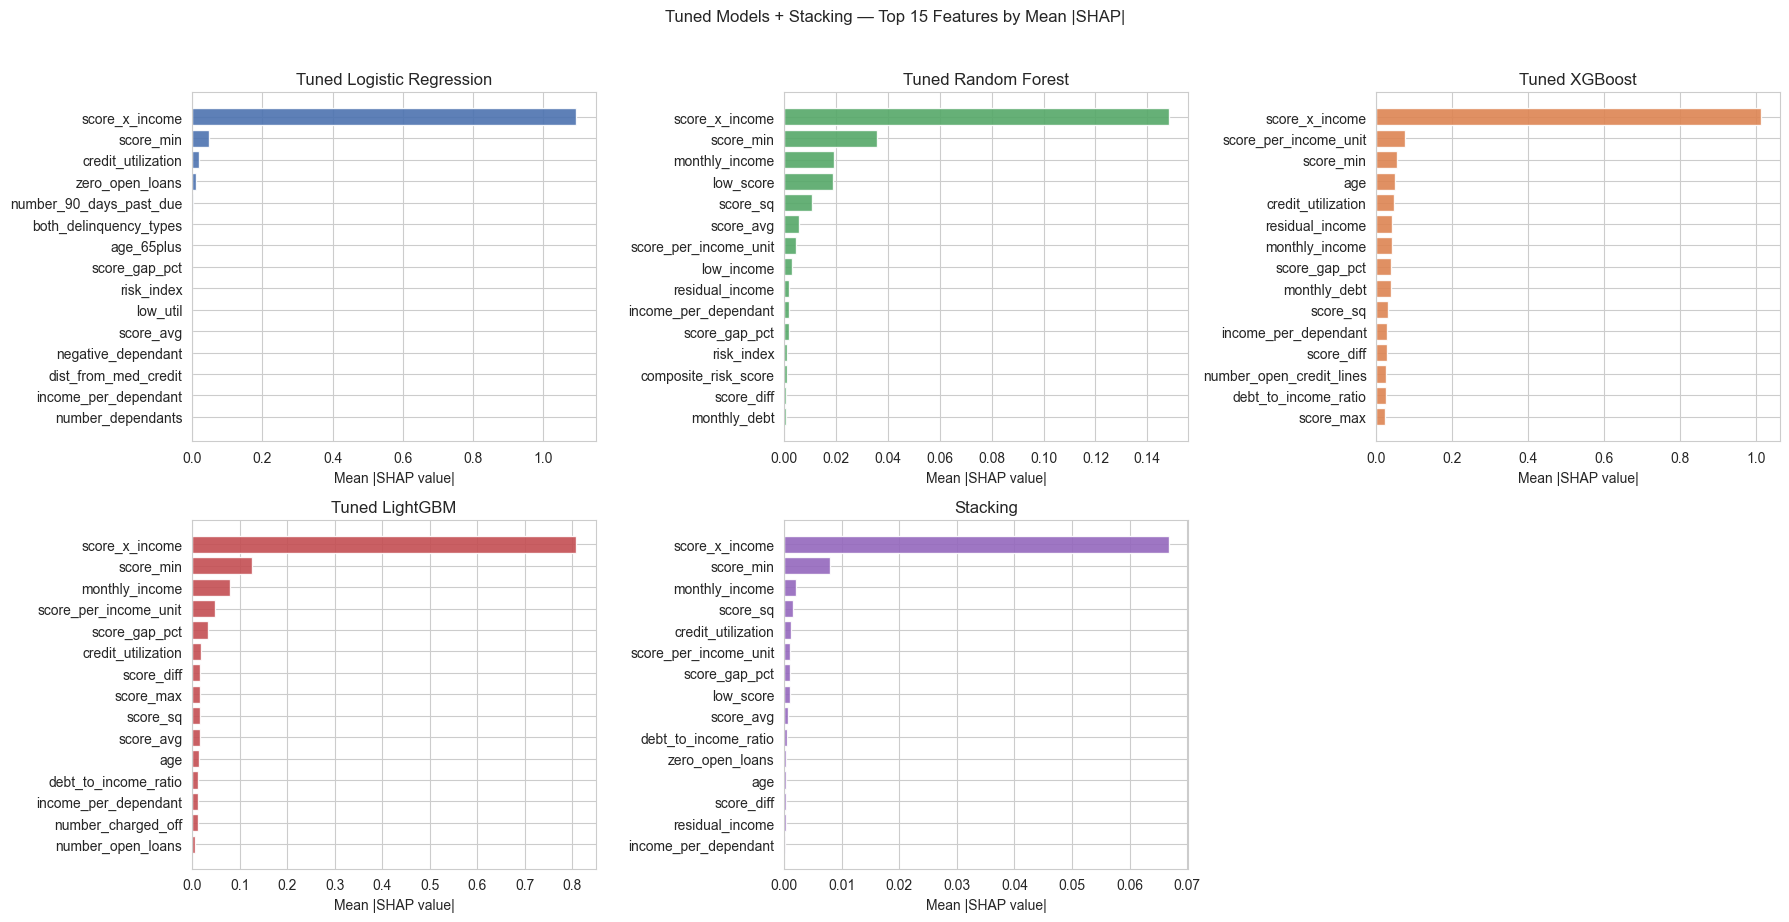

In [14]:
# Fixed SHAP comparison set: tuned models plus stacking
SHAP_COMPARE_MODELS = [
    'Tuned Logistic Regression',
    'Tuned Random Forest',
    'Tuned XGBoost',
    'Tuned LightGBM',
    'Stacking',
]
SHAP_COMPARE_TOP_K = 15
SHAP_COMPARE_SAMPLE_ROWS = 1000
SHAP_STACKING_SAMPLE_ROWS = 200
SHAP_STACKING_BACKGROUND_ROWS = 100
SHAP_STACKING_NSAMPLES = 200
SHAP_COMPARE_RANDOM_STATE = SEED

all_trained_models = {**models, **tuned_models, 'Stacking': stack}
missing_models = [m for m in SHAP_COMPARE_MODELS if m not in all_trained_models]
if missing_models:
    raise ValueError(
        'Missing models for SHAP comparison. Re-run model training cells first. '
        f'Missing: {missing_models}'
    )

for model_name in SHAP_COMPARE_MODELS:
    ensure_holdout_eval(model_name)


def _extract_shap_2d(raw_shap_values):
    """Normalize SHAP outputs to (n_samples, n_features)."""
    if isinstance(raw_shap_values, shap.Explanation):
        values = raw_shap_values.values
    else:
        values = raw_shap_values

    if isinstance(values, list):
        values = values[1] if len(values) > 1 else values[0]

    values = np.asarray(values)

    if values.ndim == 3:
        # shape patterns like (n_samples, n_features, n_classes)
        values = values[:, :, 1] if values.shape[-1] > 1 else values[:, :, 0]

    if values.ndim != 2:
        raise ValueError(f'Unsupported SHAP output shape: {values.shape}')

    return values


def _stratified_sample_indices(y_series, n_samples, random_state):
    """Stratified sample indices preserving class mix for SHAP plotting."""
    total = len(y_series)
    if n_samples >= total:
        return np.arange(total)

    rng = np.random.default_rng(random_state)
    y_arr = y_series.to_numpy()
    pos_idx = np.where(y_arr == 1)[0]
    neg_idx = np.where(y_arr == 0)[0]

    pos_target = int(round(n_samples * y_arr.mean()))
    if len(pos_idx) > 0:
        pos_target = max(1, min(pos_target, len(pos_idx)))
    else:
        pos_target = 0

    neg_target = n_samples - pos_target
    neg_target = min(neg_target, len(neg_idx))

    remaining = n_samples - (pos_target + neg_target)
    if remaining > 0:
        pos_room = max(0, len(pos_idx) - pos_target)
        add_pos = min(remaining, pos_room)
        pos_target += add_pos
        remaining -= add_pos

    if remaining > 0:
        neg_room = max(0, len(neg_idx) - neg_target)
        add_neg = min(remaining, neg_room)
        neg_target += add_neg

    sampled = []
    if pos_target > 0:
        sampled.append(rng.choice(pos_idx, size=pos_target, replace=False))
    if neg_target > 0:
        sampled.append(rng.choice(neg_idx, size=neg_target, replace=False))

    sampled_idx = np.concatenate(sampled)
    rng.shuffle(sampled_idx)
    return sampled_idx


sample_n = min(SHAP_COMPARE_SAMPLE_ROWS, len(X_val))
sample_idx = _stratified_sample_indices(y_val, sample_n, SHAP_COMPARE_RANDOM_STATE)
X_val_shap = X_val.iloc[sample_idx].copy()
y_val_shap = y_val.iloc[sample_idx].copy()

shap_compare_values = {}
ranking_rows = []

for model_name in SHAP_COMPARE_MODELS:
    fitted_model = holdout_model_cache[model_name]

    if isinstance(fitted_model, Pipeline):
        scaler = fitted_model.named_steps['scaler']
        lr_model = fitted_model.named_steps['model']

        X_train_scaled = pd.DataFrame(
            scaler.transform(X_train), columns=X_train.columns, index=X_train.index
        )
        X_eval_scaled = pd.DataFrame(
            scaler.transform(X_val_shap), columns=X_val_shap.columns, index=X_val_shap.index
        )

        explainer = shap.LinearExplainer(lr_model, X_train_scaled)
        raw_shap = explainer(X_eval_scaled)
        shap_vals = _extract_shap_2d(raw_shap)
        feature_frame = X_eval_scaled
        explainer_type = 'LinearExplainer'

    elif hasattr(fitted_model, 'estimators_') and hasattr(fitted_model, 'final_estimator_'):
        # Stacking model: use smaller sample/background to keep Kernel SHAP tractable.
        stack_n = min(SHAP_STACKING_SAMPLE_ROWS, len(X_val_shap))
        stack_idx = _stratified_sample_indices(y_val_shap, stack_n, SHAP_COMPARE_RANDOM_STATE + 17)
        X_stack = X_val_shap.iloc[stack_idx].copy()

        bg_n = min(SHAP_STACKING_BACKGROUND_ROWS, len(X_train))
        background = shap.sample(X_train, bg_n, random_state=SEED)

        explainer = shap.KernelExplainer(fitted_model.predict_proba, background)
        raw_shap = explainer.shap_values(X_stack, nsamples=SHAP_STACKING_NSAMPLES)
        shap_vals = _extract_shap_2d(raw_shap)
        feature_frame = X_stack
        explainer_type = 'KernelExplainer'

    else:
        explainer = shap.TreeExplainer(fitted_model)
        raw_shap = explainer(X_val_shap)
        shap_vals = _extract_shap_2d(raw_shap)
        feature_frame = X_val_shap
        explainer_type = 'TreeExplainer'

    mean_abs = np.abs(shap_vals).mean(axis=0)
    feature_names = list(feature_frame.columns)

    model_rank = pd.DataFrame({
        'Model': model_name,
        'Feature': feature_names,
        'MeanAbsSHAP': mean_abs,
    }).sort_values('MeanAbsSHAP', ascending=False).reset_index(drop=True)
    model_rank['RankWithinModel'] = np.arange(1, len(model_rank) + 1)

    ranking_rows.append(model_rank)
    shap_compare_values[model_name] = {
        'values': shap_vals,
        'features': feature_frame,
        'feature_names': feature_names,
        'explainer_type': explainer_type,
        'n_samples': len(feature_frame),
    }

shap_compare_rankings = pd.concat(ranking_rows, ignore_index=True)
shap_compare_importance_pivot = shap_compare_rankings.pivot(
    index='Feature', columns='Model', values='MeanAbsSHAP'
).fillna(0.0)

print('SHAP comparison models:')
for m in SHAP_COMPARE_MODELS:
    p = shap_compare_values[m]
    print(f'- {m} ({p["explainer_type"]}, n={p["n_samples"]})')

summary_cols = ['Model', 'Feature', 'MeanAbsSHAP', 'RankWithinModel']
summary_top = shap_compare_rankings[shap_compare_rankings['RankWithinModel'] <= SHAP_COMPARE_TOP_K]
summary_top = summary_top.sort_values(['Model', 'RankWithinModel'])

# Bar subplot comparison: top mean absolute SHAP per model
n_models = len(SHAP_COMPARE_MODELS)
ncols = 3 if n_models > 4 else 2
nrows = int(np.ceil(n_models / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4.5 * nrows))
axes = np.atleast_1d(axes).flatten()

for idx, model_name in enumerate(SHAP_COMPARE_MODELS):
    ax = axes[idx]
    top_df = summary_top[summary_top['Model'] == model_name].copy()
    top_df = top_df.sort_values('MeanAbsSHAP', ascending=True)

    base_name = model_name.replace('Tuned ', '')
    color = MODEL_COLORS.get(base_name, plt.cm.tab10(idx % 10))

    ax.barh(top_df['Feature'], top_df['MeanAbsSHAP'], color=color, alpha=0.9)
    ax.set_title(model_name)
    ax.set_xlabel('Mean |SHAP value|')

for ax in axes[len(SHAP_COMPARE_MODELS):]:
    ax.axis('off')

plt.suptitle(f'Tuned Models + Stacking — Top {SHAP_COMPARE_TOP_K} Features by Mean |SHAP|', y=1.02)
plt.tight_layout()
plt.show()


The SHAP table reveals that `score_x_income` (the interaction of minimum credit score and monthly income) dominates stacking's attributions, while `score_min` and `monthly_income` independently appear in the top features across multiple models. Tree models tend to spread importance across more features,  while LR concentrates on a few strong signals. 

At this point, I chose to use the Tuned XGBoost model for the submission. This is because 

1) It still aligns with the other models in terms of performance metrics, so I am not sacrificing quality
2) It places more importance on other features. If any of these models are theoretically put into production, there is potential that the input features drift/change over time. If this happens (to credit score and monthly income for example), then all of the other models may degrade in quality much faster than the XGBoost. Although the XGBoost also places a high emphasis on the same columns, there is still some weight distributed to the others.

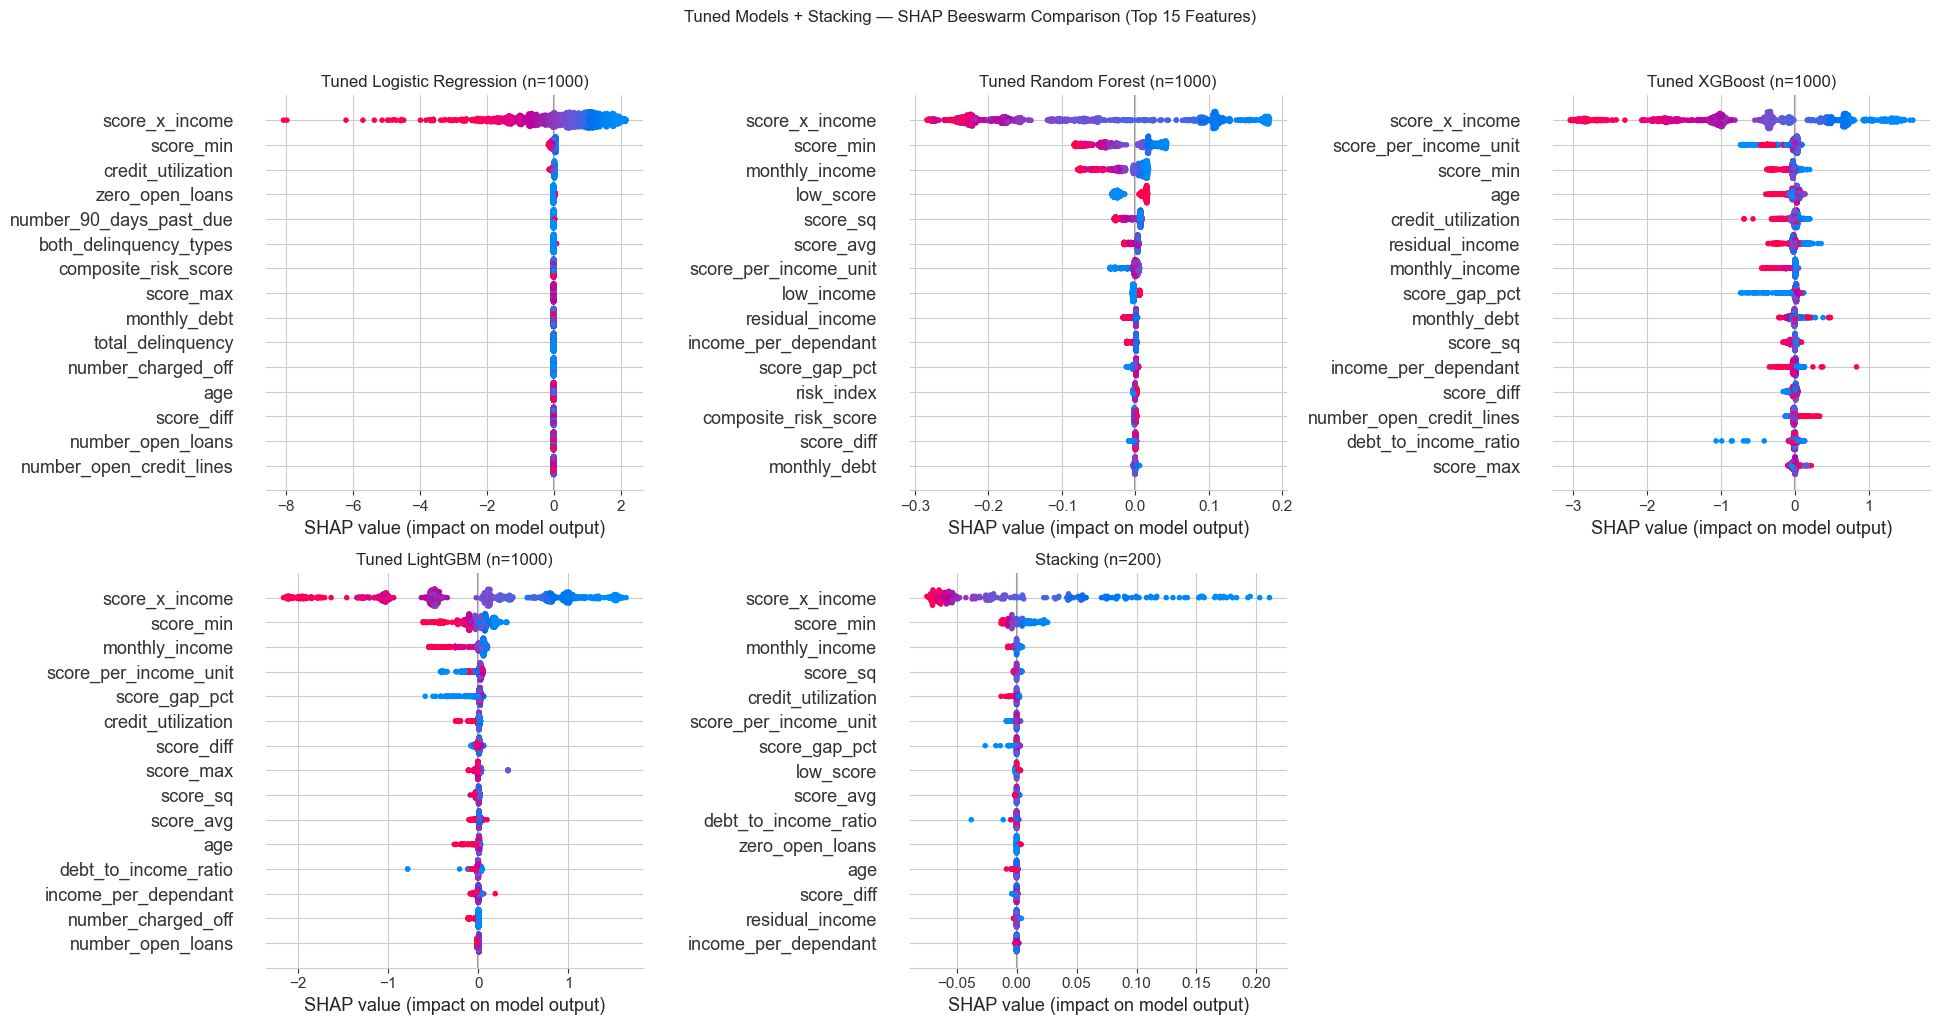

In [15]:
# Beeswarm subplot comparison for tuned models + stacking
n_models = len(SHAP_COMPARE_MODELS)
ncols = 3 if n_models > 4 else 2
nrows = int(np.ceil(n_models / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(6.5 * ncols, 5 * nrows))
axes = np.atleast_1d(axes).flatten()

for idx, model_name in enumerate(SHAP_COMPARE_MODELS):
    ax = axes[idx]
    payload = shap_compare_values[model_name]

    plt.sca(ax)
    shap.summary_plot(
        payload['values'],
        payload['features'],
        feature_names=payload['feature_names'],
        max_display=SHAP_COMPARE_TOP_K,
        plot_type='dot',
        show=False,
        color_bar=False,
        plot_size=None,
    )
    ax.set_title(f"{model_name} (n={payload['n_samples']})")

for ax in axes[len(SHAP_COMPARE_MODELS):]:
    ax.axis('off')

plt.suptitle(
    f'Tuned Models + Stacking — SHAP Beeswarm Comparison (Top {SHAP_COMPARE_TOP_K} Features)',
    y=1.02,
)
plt.tight_layout()
plt.show()


The beeswarm plots also give a visual representation of how the features impact the model. We can see that higher values of `score_x_income` lead to a lower default probability for all models. The logistic regression SHAP plot reinforces the idea that the regularization zeroed out many of the features. 

## Final Model & Submission

For the submission, we retrain the chosen model on all training data (no held-out set) to maximize the information available to the model. The optimal threshold for classification is chosen by finding the best F1.5 score. Test features use `full_fe_params` computed from all training rows, maintaining the same leakage-free pattern used during development.

In [16]:
use_calibration = True

In [ ]:
# Build validation probabilities + threshold for the same final report model.
FINAL_REPORT_MODEL = 'Tuned XGBoost'
final_base = clone(tuned_models[FINAL_REPORT_MODEL])

if use_calibration:
    # Calibrate on training split, then score holdout validation.
    val_cal_model = CalibratedClassifierCV(clone(final_base), method='sigmoid', cv=5)
    val_cal_model.fit(X_train, y_train)
    final_val_proba = val_cal_model.predict_proba(X_val)[:, 1]

    # Threshold is selected with calibration enabled inside inner CV on train only.
    optimal_threshold, threshold_std, _ = select_threshold_via_inner_cv(
        final_base, X_train, y_train, calibrate=True
    )
    print(f'Using calibrated validation probabilities for {FINAL_REPORT_MODEL}.')
    print(f'CV-selected calibrated threshold: {optimal_threshold:.4f} (std: {threshold_std:.4f})')
else:
    # Uncalibrated holdout probabilities from cached evaluation.
    final_val_proba = holdout_proba_cache[FINAL_REPORT_MODEL]
    optimal_threshold, threshold_std, _ = select_threshold_via_inner_cv(
        final_base, X_train, y_train, calibrate=False
    )
    print(f'Using calibrated validation probabilities for {FINAL_REPORT_MODEL}.')

Using calibrated validation probabilities for Tuned XGBoost.
CV-selected calibrated threshold: 0.1168 (std: 0.0040)


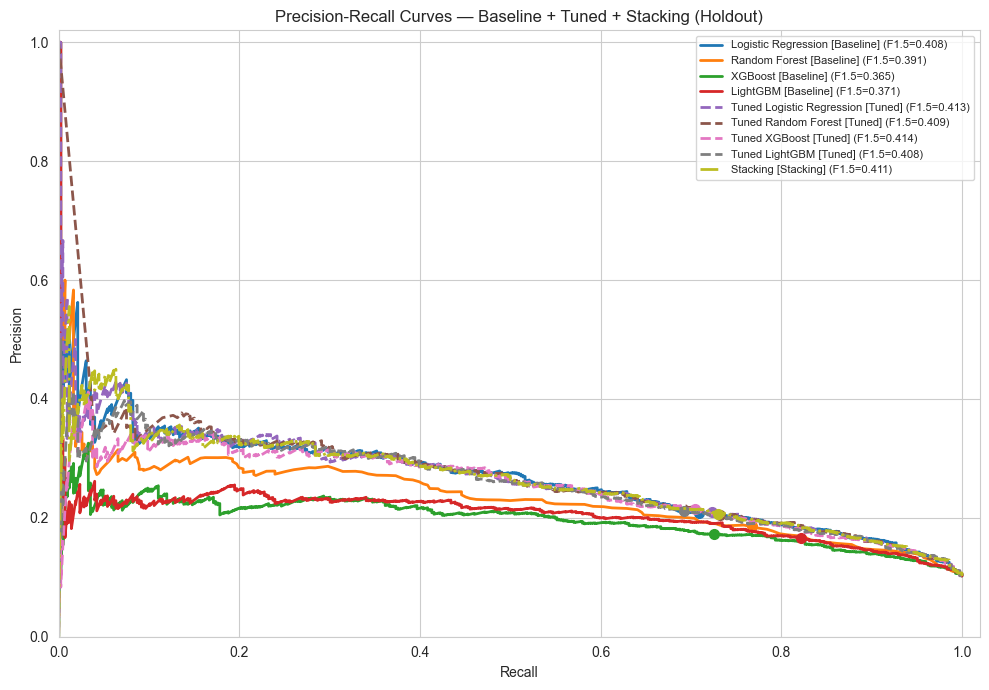

,Model,Group,Precision,Recall,F1.5,Weighted Log Loss,AUC
6,Tuned XGBoost,Tuned,0.215,0.704,0.414,0.6166,0.773
4,Tuned Logistic Regression,Tuned,0.210,0.723,0.413,0.5652,0.776
8,Stacking,Stacking,0.207,0.730,0.411,0.9769,0.776
5,Tuned Random Forest,Tuned,0.206,0.732,0.409,0.5669,0.777
7,Tuned LightGBM,Tuned,0.212,0.692,0.408,0.5748,0.773
0,Logistic Regression,Baseline,0.209,0.709,0.408,0.5660,0.777
1,Random Forest,Baseline,0.185,0.768,0.391,1.0402,0.750
3,LightGBM,Baseline,0.166,0.822,0.371,0.7929,0.733
2,XGBoost,Baseline,0.172,0.725,0.365,1.3074,0.720


In [18]:
# Precision-Recall comparison across all models (holdout)
# Self-contained: reads from holdout caches, no dependency on final_val_proba
baseline_model_names = [
    'Logistic Regression',
    'Random Forest',
    'XGBoost',
    'LightGBM',
]
tuned_model_names = [
    'Tuned Logistic Regression',
    'Tuned Random Forest',
    'Tuned XGBoost',
    'Tuned LightGBM',
]
stack_model_names = ['Stacking']

compare_model_names = baseline_model_names + tuned_model_names + stack_model_names
available_models = [m for m in compare_model_names if m in all_trained_models]

if not available_models:
    print('No baseline/tuned/stacking models available. Run model comparison and tuning cells first.')
else:
    for model_name in available_models:
        ensure_holdout_eval(model_name)

    fig, ax = plt.subplots(figsize=(10, 7))
    colors = sns.color_palette('tab10', n_colors=len(available_models))
    compare_rows = []

    for color, model_name in zip(colors, available_models):
        proba = holdout_proba_cache[model_name]
        pr_prec, pr_rec, _ = precision_recall_curve(y_val, proba)

        row = holdout_metric_cache[model_name]
        th = row['Threshold']

        preds = (proba >= th).astype(int)
        prec_t = precision_score(y_val, preds, zero_division=0)
        rec_t = recall_score(y_val, preds, zero_division=0)
        fb_t = fbeta_score(y_val, preds, beta=BETA, zero_division=0)

        if model_name.startswith('Tuned'):
            group = 'Tuned'
        elif model_name == 'Stacking':
            group = 'Stacking'
        else:
            group = 'Baseline'

        linestyle_map = {'Baseline': '-', 'Tuned': '--', 'Stacking': '-.'}

        ax.plot(
            pr_rec,
            pr_prec,
            lw=2,
            linestyle=linestyle_map[group],
            color=color,
            label=f'{model_name} [{group}] ({fbeta_label}={fb_t:.3f})',
        )
        ax.plot(rec_t, prec_t, 'o', color=color, markersize=7)

        compare_rows.append({
            'Model': model_name,
            'Group': group,
            'Precision': prec_t,
            'Recall': rec_t,
            fbeta_label: fb_t,
            'Weighted Log Loss': row['Weighted Log Loss'],
            'AUC': row['AUC'],
        })

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curves — Baseline + Tuned + Stacking (Holdout)')
    ax.set_xlim([0, 1.02])
    ax.set_ylim([0, 1.02])
    ax.legend(loc='upper right', fontsize=8)
    plt.tight_layout()
    plt.show()

    compare_threshold_df = pd.DataFrame(compare_rows).sort_values([fbeta_label, 'Weighted Log Loss'], ascending=[False, True])
    display(compare_threshold_df.style.format({
        'Precision': '{:.3f}',
        'Recall': '{:.3f}',
        fbeta_label: '{:.3f}',
        'Weighted Log Loss': '{:.4f}',
        'AUC': '{:.3f}',
    }).set_caption(f'Baseline + Tuned + Stacking @ Their CV-Selected Thresholds ({fbeta_label})'))

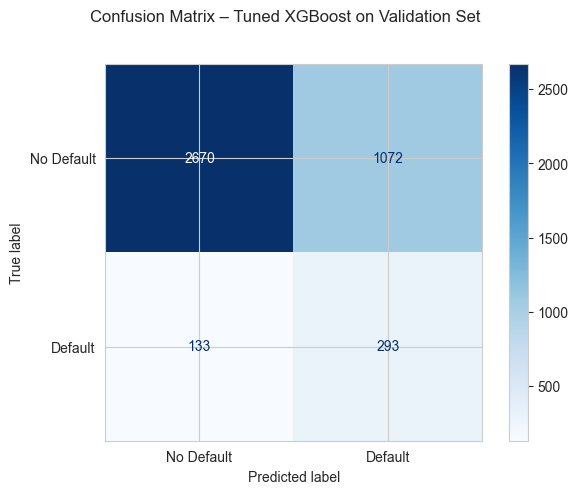

In [19]:
fb_preds = (final_val_proba >= optimal_threshold).astype(int)
fig, axes = plt.subplots(1, 1)

cm_fb = confusion_matrix(y_val, fb_preds)
ConfusionMatrixDisplay(cm_fb, display_labels=['No Default', 'Default']).plot(ax=axes, cmap='Blues')
axes.set_title(f'')

plt.suptitle('Confusion Matrix – Tuned XGBoost on Validation Set', y=1.02)
plt.tight_layout()
plt.show()


The confusion matrix above shows how the XGBoost model performed on the held-out validation data. We can see that due to the over-emphasis on recall, the model does not have many false negatives. However, it does result in a lot of false positives. 

My decision on beta was relatively abritrary. I had tried BETA=2, but I found that the model detected too many false positives. In an ideal scenario, I would calculate the expense of a false negative (how much does the company lose on an average default), and calculate the average profit of a customer that does not default. This way, I could balance out the false positives and false negatives from a profit perspective.


In [20]:
# Recompute test features using full-data statistics for final submission
X_test_final, _ = engineer_features(test, fe_params=full_fe_params)

# Apply same constant-column drop and feature ordering learned from train split
X_test_final = X_test_final.drop(columns=constant_cols, errors='ignore')
X_test_final = X_test_final.reindex(columns=selected_feature_cols, fill_value=0)
X_final_train = X.reindex(columns=selected_feature_cols, fill_value=0)

# Retrain the chosen final report model on ALL training data
final_base = clone(tuned_models[FINAL_REPORT_MODEL])

if use_calibration:
    final_model = CalibratedClassifierCV(final_base, method='sigmoid', cv=5)
    print(f'Retraining calibrated {FINAL_REPORT_MODEL} on all {len(X_final_train)} rows...')
else:
    final_model = final_base
    print(f'Retraining {FINAL_REPORT_MODEL} on all {len(X_final_train)} rows (no calibration)...')

final_model.fit(X_final_train, y)
test_proba = final_model.predict_proba(X_test_final)[:, 1]

# Base-rate threshold for confusion matrix comparison
base_rate = y.mean()
print(f'Base default rate: {base_rate:.4f}')


Retraining calibrated Tuned XGBoost on all 20839 rows...
Base default rate: 0.1022


In [21]:
# Generate submission with CV-selected threshold
submission = pd.DataFrame({
    'id': test['id'],
    'prediction': test_proba,
    'outcome': (test_proba >= optimal_threshold).astype(int),
})

# submission.to_csv('../submission.csv', index=False)

print(f'Submission saved: {submission.shape[0]} rows')


Submission saved: 1000 rows


#